In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

fraud_df = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_df = pd.read_csv("../data/raw/IpAddress_to_Country.csv")

fraud_df["signup_time"] = pd.to_datetime(fraud_df["signup_time"])
fraud_df["purchase_time"] = pd.to_datetime(fraud_df["purchase_time"])


In [2]:
fraud_df["time_since_signup"] = (
    fraud_df["purchase_time"] - fraud_df["signup_time"]
).dt.total_seconds()


In [3]:
fraud_df["hour_of_day"] = fraud_df["purchase_time"].dt.hour
fraud_df["day_of_week"] = fraud_df["purchase_time"].dt.dayofweek


In [4]:
fraud_df["transactions_per_user"] = (
    fraud_df.groupby("user_id")["user_id"].transform("count")
)


In [5]:
def ip_to_int(ip):
    return int(ip)

fraud_df["ip_int"] = fraud_df["ip_address"].apply(ip_to_int)
ip_df["lower_int"] = ip_df["lower_bound_ip_address"].apply(ip_to_int)
ip_df["upper_int"] = ip_df["upper_bound_ip_address"].apply(ip_to_int)


In [6]:
ip_df = ip_df.sort_values("lower_int")
fraud_df = fraud_df.sort_values("ip_int")

fraud_df = pd.merge_asof(
    fraud_df,
    ip_df,
    left_on="ip_int",
    right_on="lower_int",
    direction="backward"
)

fraud_df = fraud_df[fraud_df["ip_int"] <= fraud_df["upper_int"]]


In [7]:
print(fraud_df.columns)



Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'time_since_signup', 'hour_of_day', 'day_of_week',
       'transactions_per_user', 'ip_int', 'lower_bound_ip_address',
       'upper_bound_ip_address', 'country', 'lower_int', 'upper_int'],
      dtype='object')


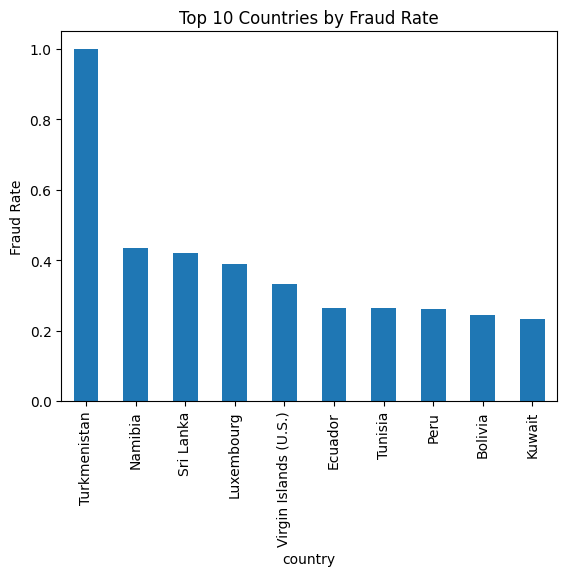

In [8]:
fraud_df.groupby("country")["class"].mean().sort_values(
    ascending=False
).head(10).plot(kind="bar")

plt.ylabel("Fraud Rate")
plt.title("Top 10 Countries by Fraud Rate")
plt.show()


In [9]:
import sklearn
from sklearn.preprocessing import StandardScaler

num_cols = [
    "purchase_value",
    "time_since_signup",
    "transactions_per_user"
]

scaler = StandardScaler()
fraud_df[num_cols] = scaler.fit_transform(fraud_df[num_cols])


In [10]:
fraud_df = pd.get_dummies(
    fraud_df,
    columns=["browser", "source", "sex", "country"],
    drop_first=True
)


In [11]:
fraud_df["class"].value_counts()



class
0    116878
1     12268
Name: count, dtype: int64

In [12]:
fraud_df = fraud_df.drop(columns=[
    "user_id",
    "device_id",
    "ip_address"
])


In [13]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])


fraud_df.dtypes


signup_time                      datetime64[ns]
purchase_time                    datetime64[ns]
purchase_value                          float64
age                                       int64
class                                     int64
                                      ...      
country_Viet Nam                           bool
country_Virgin Islands (U.S.)              bool
country_Yemen                              bool
country_Zambia                             bool
country_Zimbabwe                           bool
Length: 201, dtype: object

In [14]:
X = pd.get_dummies(
    X,
    columns=["source", "browser", "sex"],
    drop_first=True
)

NameError: name 'X' is not defined

In [ ]:
X_train.dtypes.value_counts()


bool              187
float64             7
datetime64[ns]      2
int64               2
int32               2
Name: count, dtype: int64

In [ ]:
X_train.select_dtypes(include=["datetime64[ns]"]).columns


Index(['signup_time', 'purchase_time'], dtype='object')

In [ ]:
for col in ["signup_time", "purchase_time"]:
    fraud_df[col] = pd.to_datetime(fraud_df[col])

fraud_df["signup_time_sec"] = (
    fraud_df["signup_time"] - fraud_df["signup_time"].min()
).dt.total_seconds()

fraud_df["purchase_time_sec"] = (
    fraud_df["purchase_time"] - fraud_df["signup_time"]
).dt.total_seconds()


In [ ]:
fraud_df = fraud_df.drop(columns=["signup_time", "purchase_time"])


In [ ]:
X = fraud_df.drop(columns=["class"])
y = fraud_df["class"]


In [ ]:
cat_cols = X.select_dtypes(include="object").columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train, y_train
)


In [ ]:
y_train_resampled.value_counts()


class
0    93502
1    93502
Name: count, dtype: int64

In [ ]:
fraud_df.to_csv("../data/processed/fraud_processed.csv", index=False)
